# Libraries and data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from Node import Node
from Tree import Tree
from Genetic_DT import Genetic
from Genetic_Ensemble import Genetic_Ensemble 
from Utils import model_pred, model_prob, score, plot_models, plot_params

seed = 12
np.random.seed(seed)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
data_dict = {}

data_wine = load_wine()
df_wine = pd.DataFrame(data_wine['data'], columns=data_wine['feature_names'])
df_wine.drop_duplicates(inplace=True)
features_wine = data_wine['feature_names']
targets_wine = data_wine['target_names']

data_dict['wine'] = {}
data_dict['wine']['X'] = df_wine.to_numpy()
data_dict['wine']['Y'] = data_wine['target']
data_dict['wine']['features'] = features_wine
data_dict['wine']['targets'] = targets_wine

df_fetal = pd.read_csv("fetal_health.csv")
df_fetal.drop_duplicates(inplace=True)
X_fetal = df_fetal.iloc[:,:-1]
features_fetal = X_fetal.columns.tolist()
targets_fetal = np.array(['class_0', 'class_1', 'class_2'])
Y_fetal = df_fetal.iloc[:,-1] - 1

data_dict['health'] = {}
data_dict['health']['X'] = X_fetal
data_dict['health']['Y'] = Y_fetal
data_dict['health']['features'] = features_fetal
data_dict['health']['targets'] = targets_fetal

***
***
***

# Initial Parameters Analysis

Number of models: [20, 30, 35, 40, 50 ,70]
Number of epochs: [75, 100, 125, 150]
Size of Population: [75, 100, 125, 150, 200]

Few models reached the same score of the Random Forest (baseline algorithm)

Based on execution time and gain on the score metric, we choose to perform the study with the following parameters intervals:

Number of models: [30, 35]
Number of epochs: [100, 200]
Size of Population: [125, 200]

In [3]:
res_AG = pd.read_csv("resultados_AG.csv")
res_AG.drop(columns = ['Unnamed: 0'], inplace = True)
res_AG.loc[res_AG['score_pos'] == res_AG['score_pos'].max()]

,n_models,n_epochs,n_population,score_pos,time
3,20.000,75.000,150.000,0.981,140.051
27,30.000,100.000,125.000,0.981,273.879
31,30.000,125.000,100.000,0.981,237.955
52,35.000,125.000,125.000,0.981,361.880
56,35.000,150.000,100.000,0.981,347.313
65,40.000,100.000,75.000,0.981,196.178
102,70.000,75.000,125.000,0.981,551.002


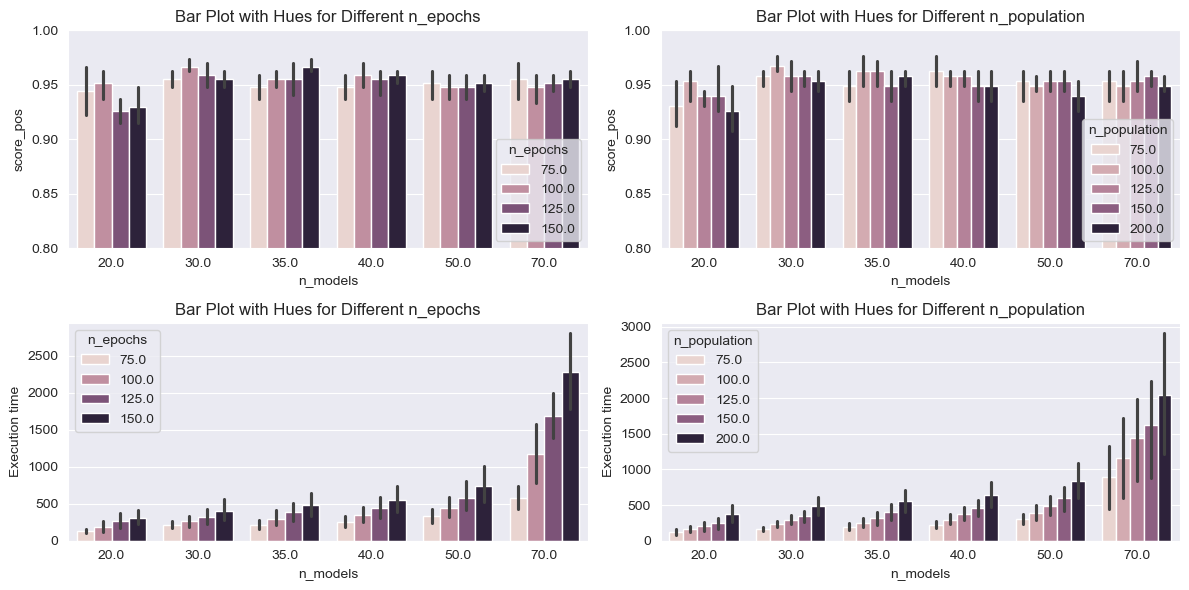

In [4]:
plot_params(res_AG)

# Genetic Decision Tree & Genetic Ensemble

In [5]:
n_models = 25
n_epochs = 125
n_population = 125
tree_depth = 16

# Opções para análise paramétrica 
# datasets = ["wine", "glass", "health"]
# mutations = [4e-2, 6e-2, 1e-2]
# elitism = [True, False]
# predation = [True, False]
# genocide = [True, False]

datasets = ["wine"]
mutations = [4e-2]
elitism = [True]
predation = [True]
genocide = [True]

scaler = StandardScaler()
results_comb = pd.DataFrame(columns = ['label', 'score_pre', 'score_pos'])
results_AG = pd.DataFrame(columns = ['modelo', 'epoch', 'best_score', 'mutation_rate'])

for data in datasets:
  models = []
  historic = {}

  for _ in range(n_models):
    model = Tree(data_dict[data]['features'], data_dict[data]['targets'] , max_depth=tree_depth)
    model.create()
    models.append(model)
    
  x_train, x_test, y_train, y_test = train_test_split(data_dict[data]['X'], data_dict[data]['Y'], test_size=0.20, random_state=seed, stratify = data_dict[data]['Y'])
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)
  x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=seed, stratify = y_train)
  
  for mut in mutations:
    for elite in elitism:
      for pred in predation:
        for gen in genocide:
          agents = []
          eli = "E" if elite else "T"
          pre = "P" if pred else ""
          gen = "G" if gen else ""
          folder_name = f"{data}_{n_models}_{n_epochs}_{n_population}_{eli}{pre}{gen}_"
          if not os.path.exists(folder_name):
            os.makedirs(folder_name)

          elit = "_Elitismo" if elite else "_Torneio"
          pr = "_Predacao" if pred else "_Sem_pred"
          gn = "_Genocidio" if gen else "_Sem_gen"
          label = str(mut) + elit + pr + gn
        
          for i, model in tqdm(enumerate(models), desc='Traning Models :: ', total=n_models):
            historic[i] = {}
            genetic = Genetic(n_population, n_epochs, model, elite, pred, gen, x_tr, y_tr, bootstrap = True, documentation = True)
            genetic.train()
            agents.append( genetic.model )
            historic[i]['gen_pop'] = genetic.results
            historic[i]['elite_pop'] = genetic.results_elite
              
            # Documenta resultados e salva imagens do treino (AG1)
            # results_AG = pd.concat([results_AG, results], ignore_index = True)
            # fig_diag = genetic.plot_diagnosis()
            # fig_pop = genetic.plot_pop()
            # fig_diag.savefig(f'{folder_name}/diagn_{label}_{i}.png')
            # fig_pop.savefig(f'{folder_name}/pop_{label}_{i}.png')
            # plt.close(fig_diag)
            # plt.close(fig_pop)
              
          y_pred, y_probs = model_pred(len(data_dict[data]['targets']), agents, x_test)
          score_pre = score(y_pred, y_test)

          # Documenta resultados e salva imagens do treino (AG2)
          # fig_model = plot_models(historic)
          # fig_model.savefig(f'{folder_name}/model_{label}.png')
          # plt.close(fig_model)

          noise = np.random.normal(0, 0.1, x_tr.shape)
          tr_noisy = x_tr + noise
          x_noisy = np.vstack([tr_noisy, x_val])
          y_train_ensemb = np.concatenate([y_tr, y_val])
          
          ensemble_test = Genetic_Ensemble(agents, 100, 150, x_noisy, y_train_ensemb,  bootstrap = True)
          ensemble_test.train()
          # ensemble_test.plot_diagnosis()
          # ensemble_test.plot_pop()
          y_pred_prob, weighted_probs = model_prob(data = x_test, n_class = len(data_dict[data]['targets']),
                                                   agents = agents, agent_weight = ensemble_test.best)
          score_pos = score(y_pred_prob, y_test)
            
          # Documenta resultados e salva imagens do treino
          # results_comb.loc[len(results_comb)] = [label, score_pre, score_pos]
          # results_comb.to_csv(f'{folder_name}/df_params.csv', index=False)

Traning Models ::   0%|          | 0/25 [00:00<?, ?it/s]

Score :: 0.8611111111111112
Score :: 0.9166666666666666


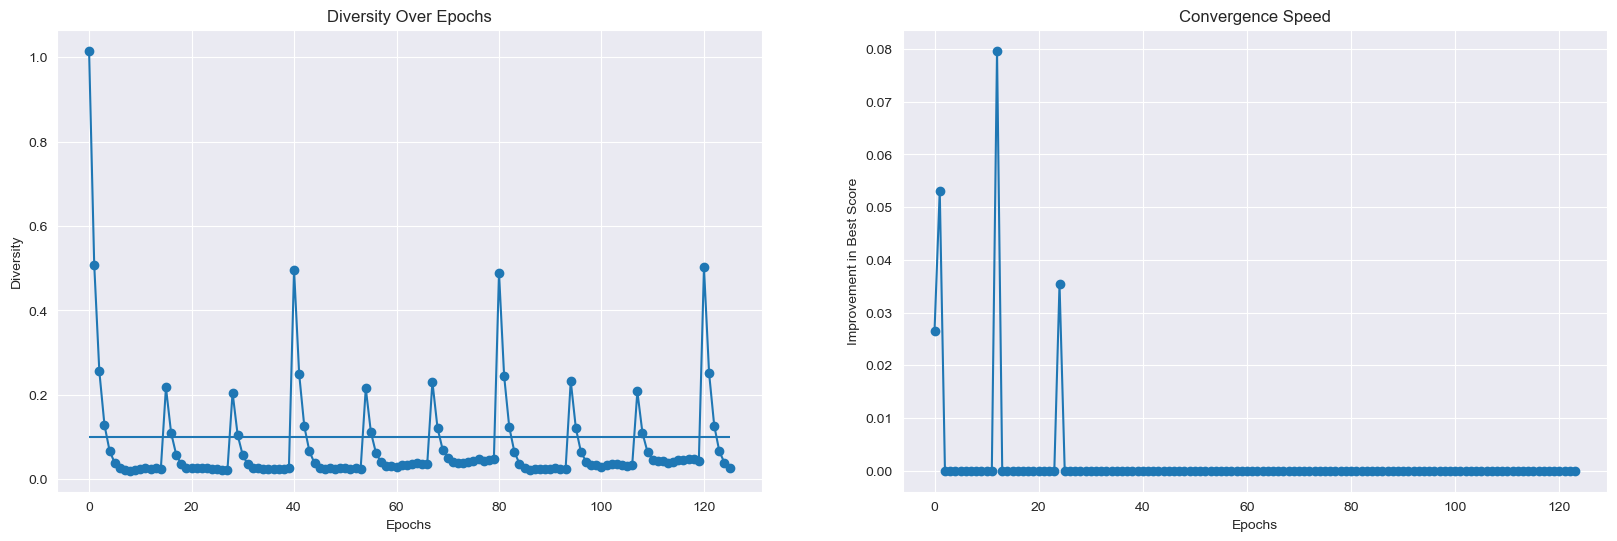

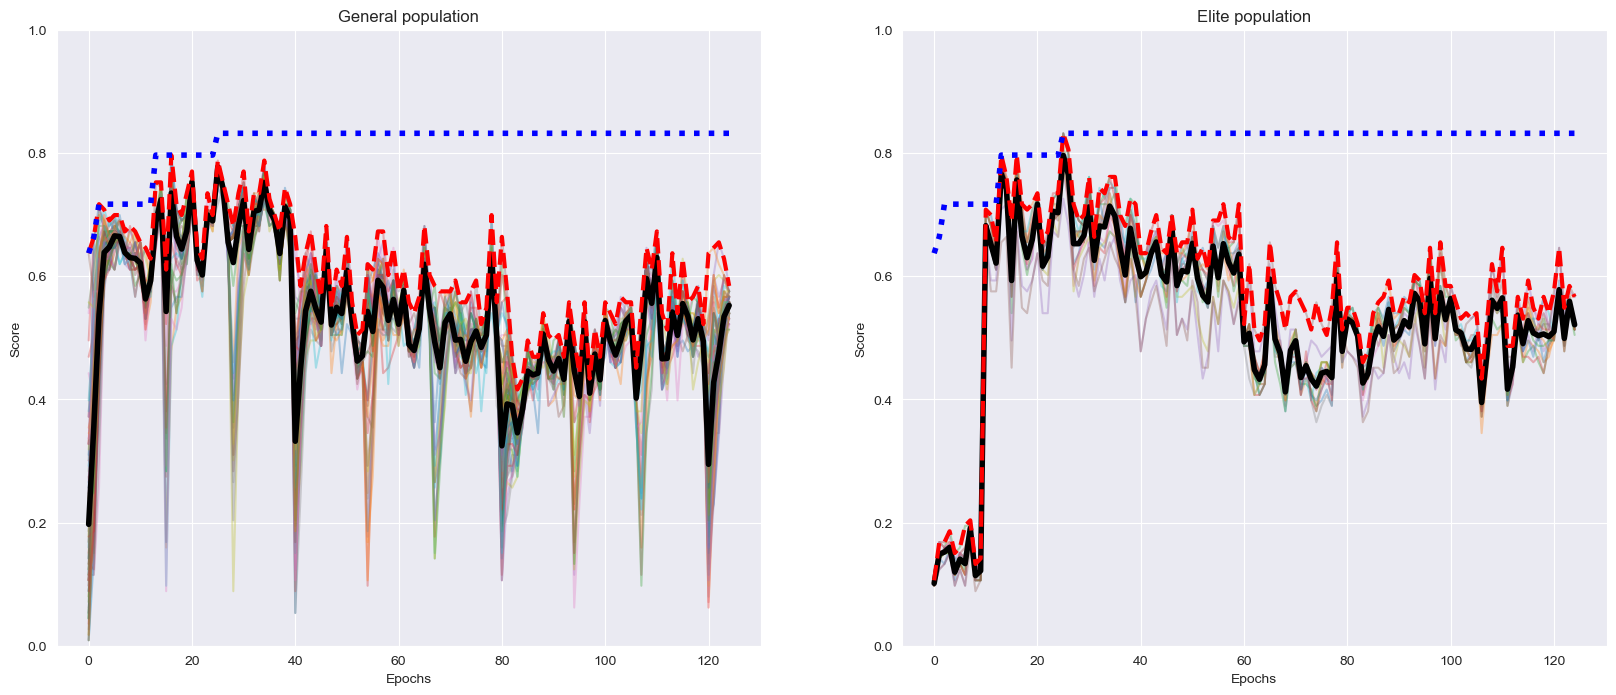

In [6]:
# Exemplo da análise para AG1
_ = genetic.plot_diagnosis()
_ = genetic.plot_pop()

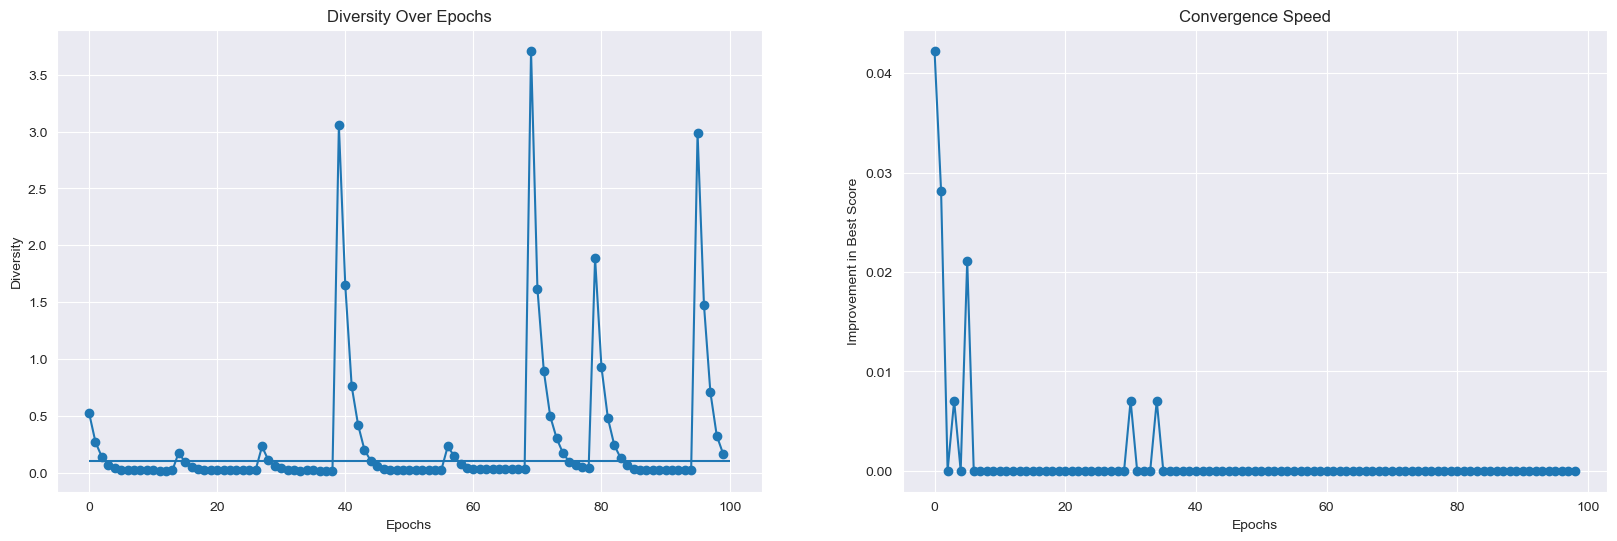

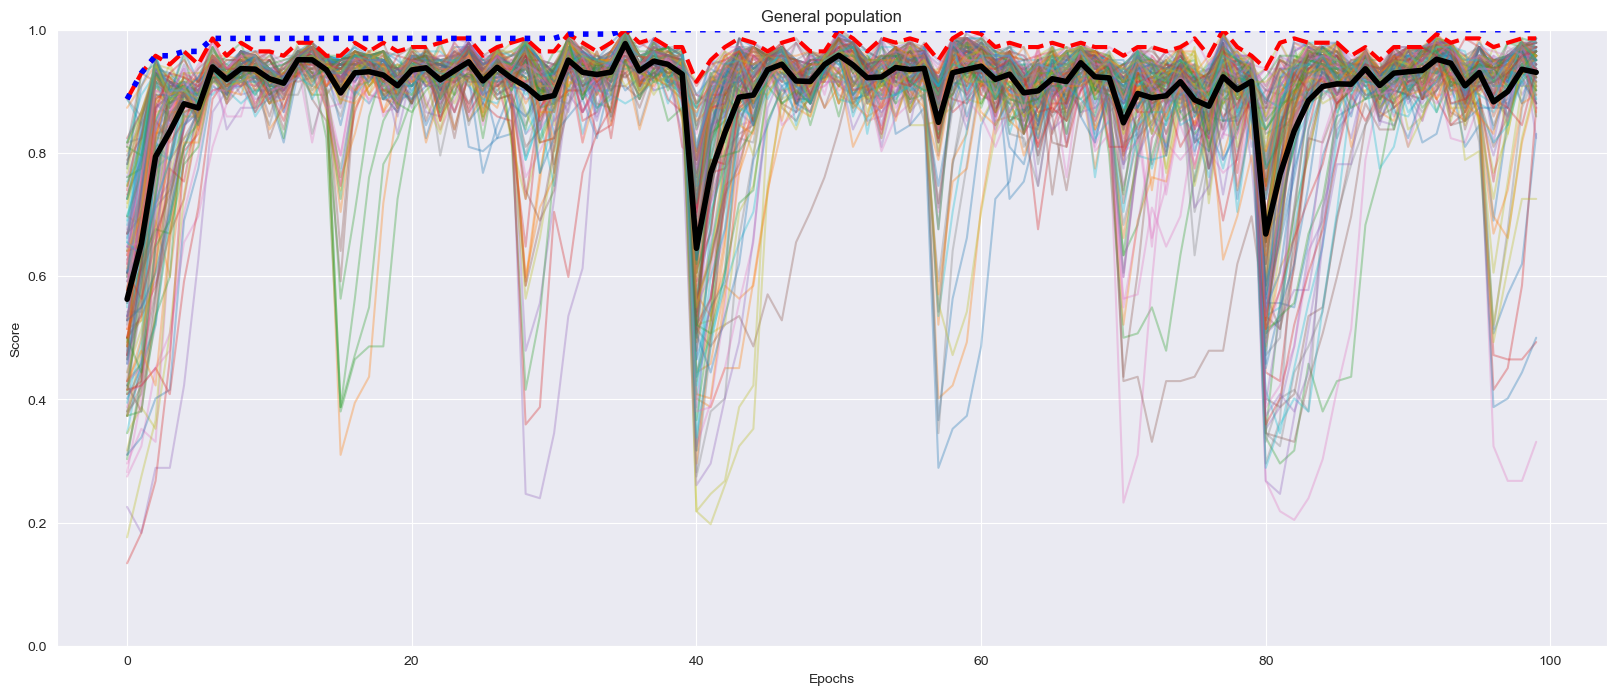

In [7]:
# Exemplo da análise para AG2
ensemble_test.plot_diagnosis()
ensemble_test.plot_pop()

***
***
***

# Results

First, a study was conducted to assess the effects of the Mutation Rate, the introduction of Predation and Genocide, and the crossover method (Elitism - the best vs all and Tournament random parents).

Following this, we examined the results on two datasets while maintaining a constant Mutation rate (0.04):

Wine dataset: A simpler dataset consisting of (178x13) dimensions.
Health dataset: A more complex dataset with (2113x21) dimensions.

In [8]:
result_params = pd.read_csv("results_analise_params.csv")
result_params

,Taxa Mutação,Predação,Genocídio,Método_x,best_score_x,Método_y,best_score_y
0,0.010,Predacao,Genocidio,Elitismo,0.972,Torneio,0.917
1,0.040,Predacao,Genocidio,Elitismo,0.972,Torneio,0.889
2,0.070,Predacao,Genocidio,Elitismo,0.833,Torneio,0.889
3,0.010,Predacao,Sem Genocídio,Elitismo,0.944,Torneio,0.944
4,0.040,Predacao,Sem Genocídio,Elitismo,0.944,Torneio,0.944
5,0.070,Predacao,Sem Genocídio,Elitismo,0.917,Torneio,0.889
6,0.010,Sem Predação,Genocidio,Elitismo,0.861,Torneio,0.972
7,0.040,Sem Predação,Genocidio,Elitismo,0.861,Torneio,0.944
8,0.070,Sem Predação,Genocidio,Elitismo,0.861,Torneio,0.917
9,0.010,Sem Predação,Sem Genocídio,Elitismo,1.000,Torneio,0.917


In [9]:
result_data = pd.read_csv("results_analise_datas.csv")
result_data

,Taxa Mutação,Método,Predação,Genocídio,Pre_Wine,Pos_Wine,Pre_Health,Pos_Health
0,0.040,Elitismo,Predacao,Genocidio,0.944,0.861,0.799,0.837
1,0.040,Elitismo,Predacao,Sem Genocídio,0.750,0.889,0.780,0.835
2,0.040,Elitismo,Sem Predação,Genocidio,0.861,0.861,0.780,0.827
3,0.040,Elitismo,Sem Predação,Sem Genocídio,0.889,0.833,0.785,0.827
4,0.040,Torneio,Predacao,Genocidio,0.889,0.889,0.799,0.827
5,0.040,Torneio,Predacao,Sem Genocídio,0.889,0.861,0.780,0.813
6,0.040,Torneio,Sem Predação,Genocidio,0.944,0.944,0.780,0.823
7,0.040,Torneio,Sem Predação,Sem Genocídio,0.889,0.861,0.790,0.837
